# Library import

In [204]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from counterplots import CreatePlot

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbalanced_make_pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, silhouette_score, roc_auc_score, recall_score, precision_score, fbeta_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer as ag_make_scorer

from scipy.spatial.distance import cdist
import dice_ml

import copy
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Data load

In [205]:
df = pd.read_csv("Data/oulad_data.csv", delimiter=',')
df.set_index("id_student", inplace=True)

df.drop(columns=["code_module", "code_presentation", "gender", "region", "highest_education", "imd_band", "age_band", "num_of_prev_attempts", "studied_credits", "disability", "TMA1", "TMA2", "TMA3", "TMA4", "TMA5", "TMA6"], inplace=True)

In [206]:
df

,final_result,week_-4,week_-3,week_-2,week_-1,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_minus_4_homepage,week_minus_4_resource,week_minus_4_subpage,week_minus_4_oucontent,week_minus_4_url,week_minus_4_glossary,week_minus_3_homepage,week_minus_3_oucontent,week_minus_3_resource,week_minus_3_subpage,week_minus_3_url,week_minus_3_externalquiz,week_minus_3_glossary,week_minus_3_forumng,week_minus_3_oucollaborate,week_minus_3_ouwiki,week_minus_2_forumng,week_minus_2_homepage,week_minus_2_subpage,week_minus_2_url,week_minus_2_externalquiz,week_minus_2_oucontent,week_minus_2_oucollaborate,week_minus_2_resource,week_minus_2_ouwiki,week_minus_2_glossary,week_minus_1_forumng,week_minus_1_homepage,week_minus_1_oucollaborate,week_minus_1_oucontent,week_minus_1_subpage,week_minus_1_url,week_minus_1_resource,week_minus_1_externalquiz,week_minus_1_ouwiki,week_minus_1_glossary,week_0_externalquiz,week_0_forumng,week_0_homepage,week_0_oucollaborate,week_0_oucontent,week_0_ouwiki,week_0_resource,week_0_subpage,week_0_url,week_0_glossary,week_1_forumng,week_1_homepage,week_1_oucollaborate,week_1_oucontent,week_1_resource,week_1_subpage,week_1_url,week_1_externalquiz,week_1_ouwiki,week_1_glossary,week_2_homepage,week_2_oucontent,week_2_url,week_2_forumng,week_2_resource,week_2_subpage,week_2_externalquiz,week_2_ouwiki,week_2_oucollaborate,week_2_glossary,week_3_externalquiz,week_3_homepage,week_3_oucontent,week_3_resource,week_3_subpage,week_3_url,week_3_forumng,week_3_ouwiki,week_3_glossary,week_3_oucollaborate,week_4_externalquiz,week_4_homepage,week_4_oucontent,week_4_resource,week_4_subpage,week_4_url,week_4_forumng,week_4_ouwiki,week_4_glossary,week_4_oucollaborate,week_5_homepage,week_5_oucollaborate,week_5_oucontent,week_5_resource,week_5_subpage,week_5_url,week_5_forumng,week_5_ouwiki,week_5_externalquiz,week_5_glossary,week_6_forumng,week_6_homepage,week_6_oucollaborate,week_6_oucontent,week_6_ouwiki,week_6_subpage,week_6_resource,week_6_url,week_6_externalquiz,week_6_glossary,week_7_homepage,week_7_oucontent,week_7_resource,week_7_subpage,week_7_forumng,week_7_oucollaborate,week_7_url,week_7_ouwiki,week_7_externalquiz,week_7_glossary,week_8_homepage,week_8_subpage,week_8_forumng,week_8_oucontent,week_8_ouwiki,week_8_resource,week_8_url,week_8_externalquiz,week_8_glossary,week_8_oucollaborate,week_9_homepage,week_9_forumng,week_9_oucontent,week_9_url,week_9_externalquiz,week_9_subpage,week_9_resource,week_9_oucollaborate,week_9_glossary,week_9_ouwiki,week_10_externalquiz,week_10_homepage,week_10_oucontent,week_10_resource,week_10_subpage,week_10_url,week_10_forumng,week_10_oucollaborate,week_10_glossary,week_10_ouwiki,week_11_homepage,week_11_resource,week_11_subpage,week_11_forumng,week_11_oucontent,week_11_url,week_11_externalquiz,week_11_oucollaborate,week_11_ouwiki,week_11_glossary,week_12_externalquiz,week_12_homepage,week_12_oucontent,week_12_resource,week_12_subpage,week_12_url,week_12_forumng,week_12_oucollaborate,week_12_glossary,week_12_ouwiki,week_13_forumng,week_13_homepage,week_13_resource,week_13_subpage,week_13_url,week_13_oucontent,week_13_externalquiz,week_13_oucollaborate,week_13_ouwiki,week_13_glossary,week_14_homepage,week_14_oucontent,week_14_resource,week_14_forumng,week_14_subpage,week_14_url,week_14_externalquiz,week_14_oucollaborate,week_14_ouwiki,week_14_glossary,week_15_homepage,week_15_resource,week_15_subpage,week_15_forumng,week_15_oucontent,week_15_url,week_15_ouwiki,week_15_oucollaborate,week_15_externalquiz,week_15_glossary,week_16_homepage,week_16_subpage,week_16_url,week_16_forumng,week_16_oucollaborate,week_16_resource,week_16_oucontent,week_16_externalquiz,week_16_ouwiki,week_16_glossary,week_17_homepage,week_17_forumng,week_17_subpage,week_17_url,we

In [207]:
week_columns = [col for col in df.columns if col.startswith("week_")]
classes_columns = []

classes = set()
for col in week_columns:
    last_part = col.split("_")[-1]
    if last_part.isalpha():
        classes.add(last_part)

classes = sorted(classes)
def ends_with_number(col):
    last_part = col.split("_")[-1]
    return last_part.isdigit()

for cls in classes:
    matching_columns = [col for col in week_columns if cls in col]
    classes_columns+=matching_columns

    df[f'n_clicks_{cls}'] = df[matching_columns].sum(axis=1)

df = df.drop(columns=week_columns)

In [208]:
categorical_features = df.select_dtypes(include=['object', 'bool']).columns
categorical_features = categorical_features.drop("final_result")

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

df["final_result"] = df["final_result"].apply(lambda x: "Pass" if x == "Distinction" else x)
df["final_result"] = df["final_result"].apply(lambda x: 0 if x == "Pass" else 1)
# 0 = Pass, 1 = Fail

cols = list(df.columns)
cols.remove("final_result")
cols.append("final_result")
df = df[cols]

In [209]:
df

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
id_student,,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33,1
28046,10,92,0,162,0,100,75,32,175,15,1
29411,24,169,4,211,1,54,74,87,193,24,0
30549,2,7,0,58,2,32,0,3,33,0,1
31173,7,162,0,212,6,228,110,44,87,2,1
33930,6,143,0,199,6,43,70,22,48,7,0
34653,3,36,0,39,0,45,5,18,64,3,1
39411,2,44,0,44,1,46,0,0,25,2,1
40184,36,511,1,485,2,47,291,83,390,30,0


In [142]:
nan_values = {col: df[col].isna().sum() for col in df.columns if df[col].isna().sum() > 0}
nan_values

{}

In [143]:
df.duplicated().sum()

0

In [144]:
#detect and drop nan values
df.dropna(inplace=True)

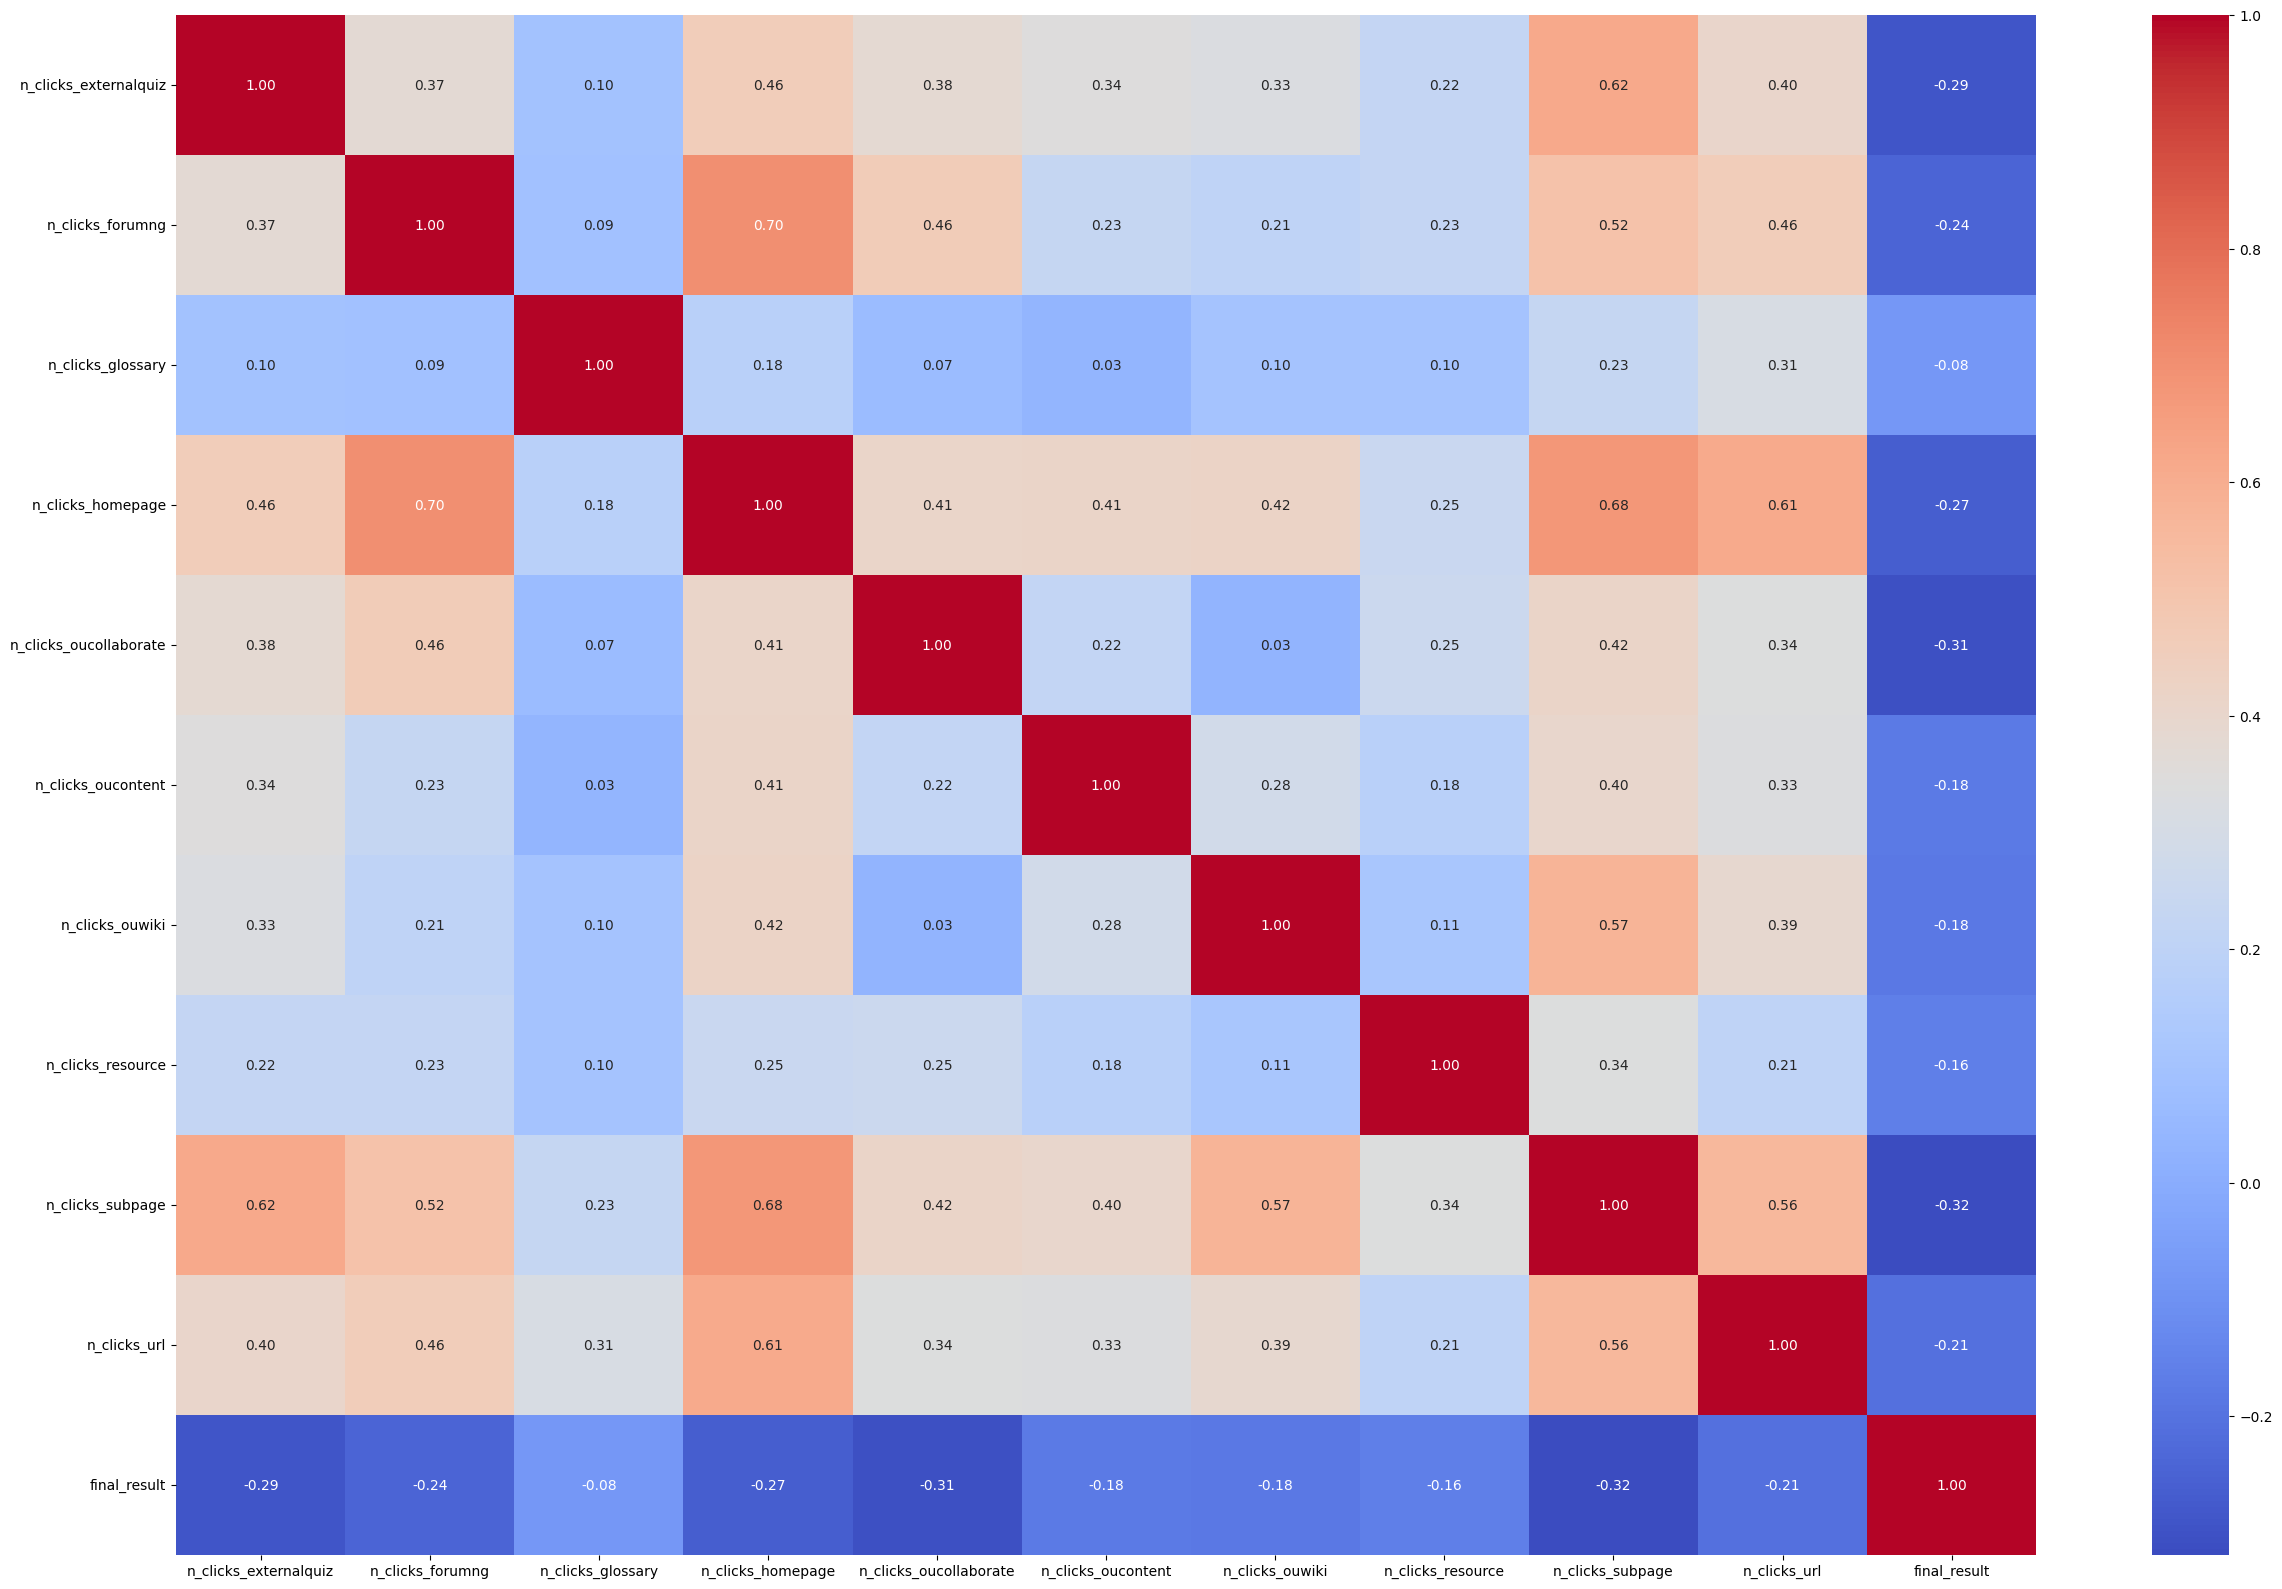

In [145]:
plt.figure(figsize=(30, 20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [146]:
print(df["final_result"].value_counts())

0    1620
1     676
Name: final_result, dtype: int64


In [147]:
encoder = OrdinalEncoder()
df[categorical_features] = encoder.fit_transform(df[categorical_features])

# Split train/test

In [124]:
# In case u want to load the already preprocessed data, run this cell
df = pd.read_csv("Data/oulad_data_preprocessed.csv", delimiter=',')
df.set_index("id_student", inplace=True)

In [148]:
X = df.drop('final_result', axis=1)
y = df['final_result']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, df['final_result'], test_size=0.3, stratify=y, random_state=42)

X_test = X_test[~X_test.index.duplicated()]
y_test = y_test[~y_test.index.duplicated()]

In [150]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)

## Random Forest

In [151]:
pipeline = imbalanced_make_pipeline(steps=[
    ('smote', SMOTE(random_state=42)), 
    ('classifier', RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42))
])

rf_model = pipeline.fit(X_train, y_train)

In [152]:
rf_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=1000, random_state=42))])

Accuracy: 0.7747093023255814
Precision: 0.6073059360730594
Recall: 0.6584158415841584
F1 Score: 0.6318289786223278
F2 Score: 0.6475170399221032
ROC AUC: 0.8095943853644624

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       486
           1       0.61      0.66      0.63       202

    accuracy                           0.77       688
   macro avg       0.73      0.74      0.73       688
weighted avg       0.78      0.77      0.78       688



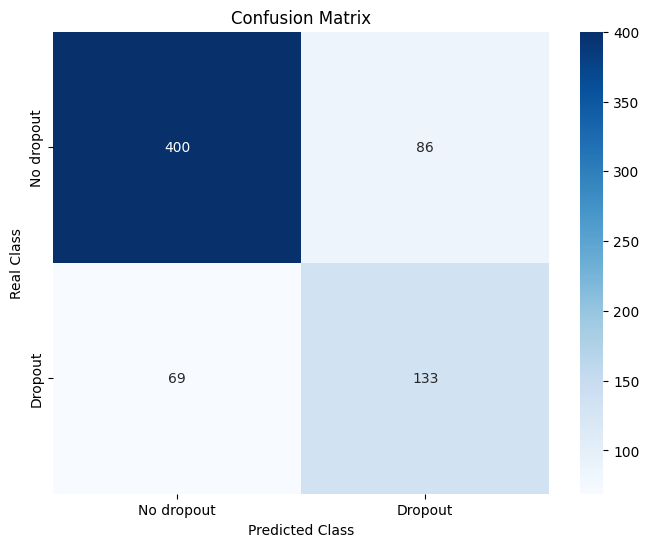

In [153]:
rf_predictions_train = pipeline.predict(X_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", f2_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No dropout', 'Dropout'], yticklabels=['No dropout', 'Dropout'])
plt.title("Confusion Matrix")
plt.ylabel("Real Class")
plt.xlabel("Predicted Class")
plt.show()

## Autogluon

In [ ]:
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

train_data = TabularDataset(X_train.join(y_train))
test_data = TabularDataset(X_test.join(y_test))

predictor = TabularPredictor(label="final_result", eval_metric=ag_make_scorer(name='f2', score_func=f2_score))
autogluon_model = predictor.fit(train_data, presets='best_quality', time_limit=3600, verbosity=0)

In [164]:
autogluon_model.leaderboard(test_data, extra_metrics=['accuracy', 'precision', 'recall', 'roc_auc'])

,model,score_test,accuracy,precision,recall,roc_auc,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTrees_r4_BAG_L1,0.688540,0.741279,0.543796,0.737624,0.821456,0.753023,f2,0.087036,0.076926,0.561140,0.087036,0.076926,0.561140,1,True,14
1,RandomForest_r34_BAG_L1,0.683521,0.752907,0.561538,0.722772,0.818064,0.757844,f2,0.098020,0.077316,0.566654,0.098020,0.077316,0.566654,1,True,13
2,ExtraTrees_r172_BAG_L1,0.675803,0.758721,0.572000,0.707921,0.812034,0.809499,f2,0.089299,0.083943,0.548800,0.089299,0.083943,0.548800,1,True,9
3,ExtraTrees_r126_BAG_L1,0.668246,0.757267,0.570850,0.698020,0.815711,0.823198,f2,0.091556,0.083573,0.579790,0.091556,0.083573,0.579790,1,True,20
4,ExtraTrees_r178_BAG_L1,0.663217,0.745640,0.552941,0.698020,0.813521,0.794972,f2,0.089338,0.081836,0.578122,0.089338,0.081836,0.578122,1,True,15
5,RandomForest_r15_BAG_L1,0.649663,0.763081,0.584416,0.668317,0.806289,0.838160,f2,0.088030,0.085413,0.622391,0.088030,0.085413,0.622391,1,True,17
6,RandomForest_r166_BAG_L1,0.645005,0.768895,0.596413,0.658416,0.808764,0.870477,f2,0.089477,0.084607,0.592698,0.089477,0.084607,0.592698,1,True,16
7,RandomForestGini_BAG_L1,0.645005,0.768895,0.596413,0.658416,0.808764,0.870477,f2,0.091424,0.080867,0.550967,0.091424,0.080867,0.550967,1,True,3
8,RandomForest_r39_BAG_L1,0.641892,0.761628,0.583333,0.658416,0.804888,0.855493,f2,0.089984,0.081000,0.588841,0.089984,0.081000,0.588841,1,True,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [165]:
autogluon_model.set_model_best(model="ExtraTrees_r4_BAG_L1")

Accuracy: 0.7412790697674418
Precision: 0.5437956204379562
Recall: 0.7376237623762376
F1 Score: 0.6260504201680672
F2 Score: 0.6885397412199631
ROC AUC: 0.8214562196960437

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       486
           1       0.54      0.74      0.63       202

    accuracy                           0.74       688
   macro avg       0.71      0.74      0.71       688
weighted avg       0.78      0.74      0.75       688



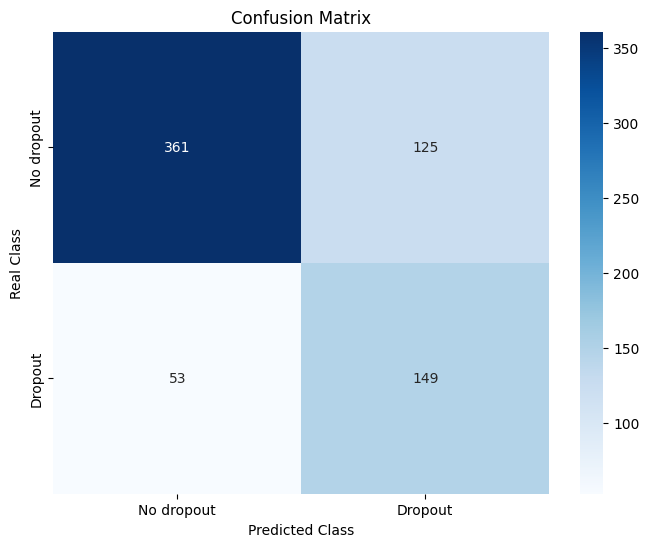

In [166]:
autogluon_predictions_train = autogluon_model.predict(X_train)

y_pred = autogluon_model.predict(test_data.drop(columns=["final_result"]))
y_proba = autogluon_model.predict_proba(test_data.drop(columns=["final_result"]))[1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", f2_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No dropout', 'Dropout'], yticklabels=['No dropout', 'Dropout'])
plt.title("Confusion Matrix")
plt.ylabel("Real Class")
plt.xlabel("Predicted Class")
plt.show()

In [167]:
model = autogluon_model._trainer.load_model('ExtraTrees_r4_BAG_L1')
predictions_train = autogluon_predictions_train

In [55]:
model = rf_model
predictions_train = rf_predictions_train

## DiCE

In [168]:
features_to_vary = [col for col in df.columns if col != "final_result"]

In [169]:
#Create DiCE explainer for generating individual counterfactuals

d = dice_ml.Data(dataframe=df,
                 continuous_features=numerical_features.tolist(),
                 outcome_name='final_result')

m = dice_ml.Model(model=model, backend="sklearn")

exp = dice_ml.Dice(d,m)

In [172]:
queries = X_test[y_test == 1].sample(5, random_state=42)
counterfactuals = exp.generate_counterfactuals(queries, total_CFs=3, desired_class=0, features_to_vary=features_to_vary)
counterfactuals.visualize_as_dataframe(show_only_changes=True)

predictions_proba = model.predict_proba(queries)
    
print(predictions_proba)

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

Query instance (original outcome : 1)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,1,8,15,45,0,5,0,9,58,2,1



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,110,-,-,-,-,-,-,2715,-,-,0
1,-,-,-,-,-,-,-,212,879,-,0
2,-,-,-,6699,-,-,-,3942,-,-,0


Query instance (original outcome : 1)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,2,44,0,150,4,186,0,43,34,5,1



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,-,-,-,-,93,-,-,-,-,-,0
1,-,-,-,-,89,-,-,-,-,-,0
2,-,-,-,-,71,1181,-,-,-,-,0


Query instance (original outcome : 1)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,0,0,0,12,1,75,0,0,0,0,1



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,-,-,-,-,157,-,-,-,2541,-,0
1,-,-,-,-,79,-,-,-,1611,-,0
2,-,-,-,-,97,-,-,-,1507,-,0


Query instance (original outcome : 1)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,1,10,0,61,0,41,0,12,38,2,1



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,-,5367,-,-,137,-,-,-,-,-,0
1,-,-,-,-,66,-,-,-,2757,-,0
2,-,3791,-,-,199,-,-,-,-,-,0


Query instance (original outcome : 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,5,106,0,187,9,331,61,47,324,19,0



Diverse Counterfactual set (new outcome: 0)


,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,final_result
0,-,-,-,-,-,1097,-,1538,-,-,-
1,-,-,-,-,-,-,-,-,544,-,-
2,-,-,81,-,-,-,-,-,-,-,-


[0.8664349  0.6589047  0.93355596 0.8638045  0.47768012]


# Group counterfactual generator algorithm with clusterization

## Functions

In [173]:
positive_train_indices = sorted(set(np.where(y_train==0)[0]).intersection(set(np.where(predictions_train == y_train)[0]))) # students who pass in the train set and are correctly classified
positive_train_set = X_train.iloc[positive_train_indices] # students who pass in the train set and are correctly classified

In [174]:
# Get the centroids of the clusters

def get_centroids(df_cluster_students, df_dropout, distances, centroids):
    centroids_students = []  # List to store the centroids of each cluster

    # Iterate over each cluster to obtain its centroid
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        index = np.argmin(distances_i)  # Find the index of the student closest to the centroid

        centroid = cluster_i.iloc[[index]]  # Get the student that represents the centroid
        centroids_students.append(df_dropout.loc[centroid.index])  # Add the centroid to the list

    # Create a dictionary that associates each cluster index with its respective centroid
    centroids_df_dict = {i: centroids_students[i] for i in range(centroids.shape[0])}

    return centroids_df_dict  # Return the dictionary of centroids


# Get the % of students from the clusters based on the selected mode

def get_students(df_cluster_students, df_dropout, distances, centroids, mode, percentage_students):
    students_dfs = []  # List to store DataFrames of selected students from each cluster

    # Iterate over each cluster to select students
    for i in range(centroids.shape[0]):
        cluster_i = df_cluster_students[df_cluster_students["Cluster"] == i]  # Filter the DataFrame by cluster
        distances_i = distances[df_cluster_students["Cluster"] == i, i]  # Get distances for the current cluster

        # Calculate the number of students to select based on the specified percentage
        n_students = int(np.ceil(percentage_students * len(cluster_i)))
        print(f"Cluster {i}: {n_students} students")  # Print the number of selected students for the cluster
        
        # Determine selection mode: closest, farthest, or random
        if mode == 'closest':
            indexes_position = np.argsort(distances_i)  # Sort distances to find closest students
            indexes = cluster_i.index[indexes_position]
            
        elif mode == 'farthest':
            indexes_position = np.argsort(distances_i)[::-1]  # Sort distances in reverse for farthest students
            indexes = cluster_i.index[indexes_position]

        elif mode == 'random':
            indexes = np.random.permutation(cluster_i.index)  # Randomly shuffle indexes

        else:
            raise ValueError("Mode value must be 'closest', 'farthest' or 'random'")  # Error for invalid mode

        # Select the desired number of students and store the corresponding DataFrame
        students = cluster_i.loc[indexes[:n_students]]
        students_dfs.append(df_dropout.loc[students.index])

    # Create a dictionary associating each cluster index with its respective selected students
    students_dfs_dict = {i: students_dfs[i] for i in range(centroids.shape[0])}

    return students_dfs_dict  # Return the dictionary of selected students

In [175]:
# This function generates the explanations for a student and teh selected students from a cluster

def cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance=False):
    # Get the number of students in the cluster
    cf_not_found = 0
    number_students_cluster = df_cluster_students.shape[0]
    
    # Initialize a list to store the counterfactual explanations
    explanations = []

    available_indexes = []
    
    # Get the indexes of the students in the cluster
    indexes = df_cluster_students.index.tolist()

    # If global feature importance is requested, calculate and return it
    if global_features_importance:
        feature_importances = explainer.global_feature_importance(df_cluster_students).summary_importance.keys()
        return tuple(explanations), indexes, list(feature_importances)

    # Generate counterfactuals for each student in the cluster
    for i in range(number_students_cluster):
        try:
            explanations.append(
                explainer.generate_counterfactuals(
                    df_cluster_students.iloc[[i]],  # Select the current student
                    total_CFs=1,  # Generate a single counterfactual per student
                    desired_class=0,  # Aim to change the class to the opposite
                    features_to_vary=features_to_vary,  # Specify which features can be modified in the counterfactual
                    verbose=0  # Suppress verbose output
                )
            )

            available_indexes.append(indexes[i])

        except Exception as e:
            cf_not_found += 1
            continue
            
    # Return the explanations and indexes; return None for feature importance if not requested
    return tuple(explanations), available_indexes, None, cf_not_found


# This function generates a CFE explanation that works for the selected students of the clusters

def GCFE_features_clustering(df_cluster_students, positive_train_set, model, explainer, features_to_vary, sample_size_percentage=0.5, n_features_percentage=0.3, global_features_importance=False):
    cf_label = 0  # Label for the counterfactual
    sampling_set = positive_train_set  # Dataset to sample counterfactual values from
    features_to_vary_idx = [df_cluster_students.columns.get_loc(col) for col in features_to_vary if col in df_cluster_students.columns] # Indices of features to vary

    # Determine the number of samples to generate GCFE values
    sample_size_gcfe_pairs = int(np.ceil(sample_size_percentage * len(sampling_set)))

    while True:  # Loop until a valid GCFE is found     
        gcfe_values = [] # List to store GCFE values
        students = []  # List to store the original student data
        students_and_cfe = []  # List to store both original and counterfactual data for students
        gcfe_values_coverage = []  # List to store GCFE values that cover the criteria
        feature_directions = []  # List to store the direction of changes for features
        changes_dict = {} # Dictionary to store the number of changes for each feature

        ### GENERATE COUNTERFACTUALS FOR EACH INSTANCE IN THE CLUSTER ###

        # Generate counterfactuals for each instance in the cluster
        q_cf_pair, indexes, features_importances, cf_not_found = cfe_generator_clustering(df_cluster_students, explainer, features_to_vary, global_features_importance)

        for instance in range(df_cluster_students.shape[0] - cf_not_found):
            # Get the counterfactual pair for the instance
            q_cf_pair_instance = q_cf_pair[instance]

            # Get the original data for the instance
            q = q_cf_pair_instance.cf_examples_list[0].test_instance_df.values[0]  # Original data
            
            # Add the original data to the students and students_and_cfe lists
            students.append(q)
            students_and_cfe.append(q)

            # Iterate over the counterfactual examples for the instance
            for cf_example in q_cf_pair_instance.cf_examples_list:
                # Iterate over the counterfactuals for the instance
                for index in range(cf_example.final_cfs_df.shape[0]):
                    cf = cf_example.final_cfs_df.values[index]
                    # Add the counterfactual data to the students_and_cfe list
                    students_and_cfe.append(cf)

        #################################################################################

        ### CALCULATE THE NUMBER OF CHANGES AND THE DIFFERENCES FOR EACH FEATURE ###

        # Number of counterfactuals per instance
        n_counterfactuals = q_cf_pair_instance.cf_examples_list[0].final_cfs_df.shape[0]

        # Delete target column from students and students_and_cfe
        students = [student[:-1] for student in students]
        students_and_cfe = [student[:-1] for student in students_and_cfe]
        
        # Create DataFrame for students' original data
        students_df = pd.DataFrame(students, index=indexes, columns=df_cluster_students.columns.tolist())

        # Create DataFrame for students' original and counterfactual data
        students_and_cfe_df = pd.DataFrame(students_and_cfe, columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the number of changes for each feature of the original instances and its counterfactuals
        column_n_changes_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())

        # Create DataFrame to store the differences for each feature of the original instances and its counterfactuals
        column_differences_df = pd.DataFrame(columns=df_cluster_students.columns.tolist())
        differences_list = []

        # Iterate over original instances
        for instance_idx in range(0, len(students_and_cfe_df), n_counterfactuals + 1):
            # Get the original instance
            original = students_and_cfe_df.iloc[instance_idx]
            
            # Initialize a dictionary to store the counts of differences
            counts = {col: 0 for col in students_and_cfe_df.columns}
            
            # Iterate over counterfactuals
            for cf_idx in range(1, n_counterfactuals + 1):
                cf = students_and_cfe_df.iloc[instance_idx + cf_idx]

                for col in students_and_cfe_df.columns:
                    if abs(cf[col] - original[col]) >= 0.1:
                        counts[col] += 1
                    
                if instance_idx + cf_idx < len(students_and_cfe_df):
                    contrafactual = students_and_cfe_df.iloc[instance_idx + cf_idx]
                    difference = contrafactual - original
                    difference = difference.where(abs(difference) > 0.1, 0)
                    differences_list.append(difference)
            
            # Add row to results DataFrame
            result_row = pd.DataFrame([counts], columns=students_and_cfe_df.columns)
            column_n_changes_df = pd.concat([column_n_changes_df, result_row], ignore_index=True)

        column_differences_df = pd.DataFrame(differences_list, columns=students_and_cfe_df.columns)

        column_sums = column_n_changes_df.sum()

        # Crear un diccionario con las columnas y sus sumas, ordenado de mayor a menor
        changes_dict = column_sums.to_dict()
        sorted_changes_dict = dict(sorted(changes_dict.items(), key=lambda item: item[1], reverse=True))

        # Crear una lista de nombres de columnas ordenada por la suma de los valores
        sorted_columns_list = list(sorted_changes_dict.keys())
        
        # Calculate the number of features to change
        n_features = int(np.ceil(n_features_percentage * len(features_to_vary)))
        features_changed = [col for col in sorted_columns_list[:n_features] if col in features_to_vary]
        column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]
        #################################################################################

        ### CREATE GROUP COUNTERFACTUALS ###
        # If we want to use global feature importances from DiCE
        if features_importances is not None:
            features_changed = [col for col in features_importances[:n_features] if col in features_to_vary]
            column_change = [df_cluster_students.columns.get_loc(name) for name in features_changed]

        # Determine the direction of change for each feature
        for feature in column_change[:n_features]:
            values = column_differences_df.iloc[:, feature].values
            values = values[values != 0]

            if feature in features_to_vary_idx:
                if sum(values > 0) > sum(values < 0):
                    feature_direction = 'increase'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() > students_df.iloc[:, feature].min()]
                elif sum(values > 0) < sum(values < 0):
                    feature_direction = 'decrease'
                    vals = sampling_set.iloc[:, feature].values.flatten()[sampling_set.iloc[:, feature].values.flatten() < students_df.iloc[:, feature].max()]
                else:
                    feature_direction = 'inconclusive'
                    vals = sampling_set.iloc[:, feature].values.flatten()
            else:
                feature_direction = 'inconclusive'
                vals = sampling_set.iloc[:, feature].values.flatten()
                
            feature_directions.append(feature_direction)
            gcfe_values.append(np.random.RandomState(0).choice(vals, sample_size_gcfe_pairs))
        
        # Stack GCFE values vertically
        gcfe_values = np.vstack(gcfe_values).T
        #################################################

        ### TEST COUNTERFACTUALS ###
        # Check each candidate GCFE for coverage
        for candidate in gcfe_values:
            students_df_copy = students_df.copy()
            for i, feature in enumerate(column_change[:n_features]):
                students_df_copy.iloc[:, feature] = candidate[i]

            predictions = model.predict(students_df_copy)

            if all(prediction == cf_label for prediction in predictions):
                gcfe_values_coverage.extend(candidate)
                break  # Stop if a valid GCFE is found
        
        # If GCFE values covering the criteria are found, break the loop
        if gcfe_values_coverage:
            break
        #################################################
    # Create GCFE DataFrame for visualization
    gcfe = pd.DataFrame(columns=df_cluster_students.columns.tolist())
    gcfe.loc[0, :] = '-'
    for col, val in zip(features_changed, gcfe_values_coverage):
        gcfe.loc[0, col] = val

    gcfe = gcfe.fillna('-')

    return (
        students_df.iloc[0:1],  # Selected student's data
        students_df.iloc[1:],  # Nearest neighbors' data
        list(features_changed),  # List of features that changed
        column_change,  # Indices of changed columns
        feature_directions,  # Direction of feature changes
        gcfe_values,  # GCFE values
        gcfe_values_coverage,  # Valid GCFE values
        gcfe  # Final GCFE DataFrame
    )

In [176]:
# Calculate the accuracy of the counerfactuals

def calculate_accuracy(predictions):
    # Get the total number of predictions
    total_predictions = len(predictions)
    
    # Count how many predictions are correct (correct predictions are labeled as 0)
    correct_predictions = sum(1 for pred in predictions if pred == 0)
    
    # Calculate the accuracy as a percentage
    accuracy = (correct_predictions / total_predictions) * 100
    
    # Return the calculated accuracy
    return accuracy


# Return the accuracy of the counterfactuals

def success_percentage(df_cluster_students, positive_train_set, clusters_dict, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Initialize lists to store accuracy and execution times for each loop
    accuracies = []
    execution_times = []

    # Loop through the number of iterations (n_loops)
    for run in range(n_loops):
        run_accuracies = []  # Store accuracies for the current run
        start_time_loop = time.time()  # Record the start time of the loop

        # DataFrame to store the generated counterfactuals for the cluster
        df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

        # Loop through each cluster in clusters_dict
        for cluster in clusters_dict.keys():
            print(f"Cluster {cluster}")
            # Generate counterfactuals for the current cluster using GCFE
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                df_cluster_students[cluster], positive_train_set, model, explainer,
                features_to_vary, sample_size_percentage, n_features_percentage, global_features_importance
            )
            # Concatenate generated counterfactuals to the DataFrame
            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

        # Create a deep copy of the clusters_dict to apply the counterfactuals
        dict_clusters_gcfe_applied = copy.deepcopy(clusters_dict)

        # Apply the counterfactuals from df_cluster_gcfe to the clusters_dict
        for i in range(n_clusters):
            for column in df_cluster_gcfe.columns:
                if df_cluster_gcfe.iloc[i][column] != '-':  # Apply only modified features
                    dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

        # Calculate accuracy for each cluster after applying counterfactuals
        for i in range(n_clusters):
            predictions = model.predict(dict_clusters_gcfe_applied[i])  # Get predictions for modified cluster
            accuracy = calculate_accuracy(predictions)  # Calculate accuracy
            run_accuracies.append(accuracy)  # Store accuracy for the current cluster
            print(f"Run {run + 1}, Cluster {i} accuracy: {accuracy:.2f}%")
            
        # Calculate the mean accuracy for the current run
        mean_accuracy = np.mean(run_accuracies)
        accuracies.append(mean_accuracy)  # Append mean accuracy of the run
        print(f"Run {run + 1} mean accuracy: {mean_accuracy:.2f}%")

        # Record the execution time for the current run
        end_time_loop = time.time()
        execution_time = end_time_loop - start_time_loop
        execution_times.append(execution_time)

    # Calculate overall mean accuracy after all loops
    overall_mean_accuracy = np.mean(accuracies)
    print(f"Overall mean accuracy after {n_loops} runs: {overall_mean_accuracy:.2f}%")

    # Return the overall mean accuracy and the execution times for all runs
    return overall_mean_accuracy, execution_times

## Example

In [264]:
df_dropout = df[df["final_result"] == 1].copy()
df_dropout.drop(columns=["final_result"], inplace=True)

In [265]:
df_student_clicks_features = ["n_clicks_externalquiz", "n_clicks_forumng", "n_clicks_glossary", "n_clicks_homepage", "n_clicks_oucollaborate", "n_clicks_oucontent", "n_clicks_ouwiki", "n_clicks_resource", "n_clicks_subpage", "n_clicks_url"]
df_student_clicks_features = df_dropout.columns.tolist()

In [266]:
df_student_clicks = df_dropout[df_student_clicks_features]

In [267]:
df_student_clicks

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url
id_student,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33
28046,10,92,0,162,0,100,75,32,175,15
30549,2,7,0,58,2,32,0,3,33,0
31173,7,162,0,212,6,228,110,44,87,2
34653,3,36,0,39,0,45,5,18,64,3
39411,2,44,0,44,1,46,0,0,25,2
42818,4,72,0,43,2,40,0,2,30,7
50610,0,0,0,4,0,4,0,0,5,0
59275,0,177,0,99,0,143,23,23,56,1


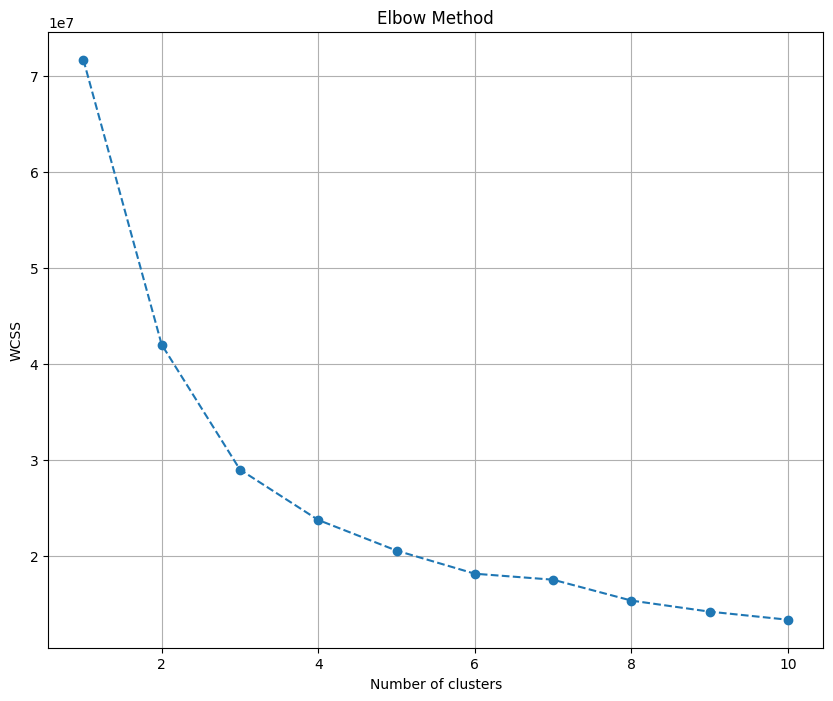

In [268]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_student_clicks)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker = "o", linestyle = "--")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [269]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, verbose=2, random_state=42)
clusters = kmeans.fit_predict(df_student_clicks)

df_centroids = kmeans.cluster_centers_
df_distances = cdist(df_student_clicks, df_centroids, 'euclidean')

Initialization complete
Iteration 0, inertia 43920212.0.
Iteration 1, inertia 31008426.296395473.
Iteration 2, inertia 29374537.72954933.
Iteration 3, inertia 29244438.646586616.
Iteration 4, inertia 29143560.531967383.
Iteration 5, inertia 29028338.559387553.
Iteration 6, inertia 29027768.44248497.
Converged at iteration 6: strict convergence.


In [270]:
cluster_list = []

for c in clusters:
    cluster_list.append(c)
           
df_student_clicks["Cluster"] = cluster_list

In [271]:
df_student_clicks

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url,Cluster
id_student,,,,,,,,,,,
27935,3,142,0,259,2,64,38,41,231,33,2
28046,10,92,0,162,0,100,75,32,175,15,0
30549,2,7,0,58,2,32,0,3,33,0,0
31173,7,162,0,212,6,228,110,44,87,2,2
34653,3,36,0,39,0,45,5,18,64,3,0
39411,2,44,0,44,1,46,0,0,25,2,0
42818,4,72,0,43,2,40,0,2,30,7,0
50610,0,0,0,4,0,4,0,0,5,0,0
59275,0,177,0,99,0,143,23,23,56,1,0


In [273]:
silhouette_avg = silhouette_score(df_student_clicks, clusters)
print(f"Silhouette score: {silhouette_avg}")

davies_bouldin = davies_bouldin_score(df_student_clicks, clusters)
print(f"Davies-Bouldin score: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(df_student_clicks, clusters)
print(f"Calinski-Harabasz score: {calinski_harabasz}")

Silhouette score: 0.49116481334825934
Davies-Bouldin score: 0.9406993181461925
Calinski-Harabasz score: 494.1615188156416


In [187]:
df_cluster_students = df_dropout.copy()
df_cluster_students["Cluster"] = clusters

In [275]:
#Describe the clusters
cluster_analysis = df_cluster_students.groupby('Cluster').describe().T
pd.set_option('display.max_rows', None)

In [276]:
cluster_analysis.loc[df_student_clicks_features]

Cluster                                0            1           2
n_clicks_externalquiz  count  499.000000    12.000000  165.000000
                       mean     3.501002    20.916667   10.024242
                       std      4.819378    13.480345   10.240374
                       min      0.000000     6.000000    0.000000
                       25%      1.000000    10.500000    4.000000
                       50%      2.000000    18.000000    7.000000
                       75%      4.000000    31.500000   12.000000
                       max     38.000000    46.000000   75.000000
n_clicks_forumng       count  499.000000    12.000000  165.000000
                       mean    59.378758  1239.416667  302.521212
                       std     59.909527   607.382081  164.732325
                       min      0.000000   642.000000    4.000000
                       25%      9.000000   796.750000  189.000000
                       50%     39.000000  1071.500000  275.000000
                       75%     94.500000  1350.000000  393.000000
                       max    284.000000  2618.000000  794.000000
n_clicks_glossary      count  499.000000    12.000000  165.000000
                       mean     4.529058    11.083333    8.666667
                       std     13.410594    19.199708   36.570569
                       min      0.000000     0.000000    0.000000
                       25%      0.000000     0.750000    0.000000
                       50%      0.000000     3.000000    0.000000
                       75%      3.000000     9.500000    6.000000
                       max    222.000000    62.000000  442.000000
n_clicks_homepage      count  499.000000    12.000000  165.000000
                       mean    92.755511   978.833333  295.345455
                       std     61.160993   332.841713  112.253668
                       min      1.000000   549.000000   30.000000
                       25%     43.000000   809.000000  214.000000
                       50%     84.000000   942.500000  271.000000
                       75%    134.000000  1044.250000  357.000000
                       max    313.000000  1631.000000  696.000000
n_clicks_oucollaborate count  499.000000    12.000000  165.000000
                       mean     3.356713    29.750000   13.672727
                       std      6.840774    21.617018   16.992166
                       min      0.000000     8.000000    0.000000
                       25%      0.000000    11.750000    3.000000
                       50%      1.000000    26.000000    9.000000
                       75%      3.500000    35.750000   19.000000
                       max     49.000000    78.000000   85.000000
n_clicks_oucontent     count  499.000000    12.000000  165.000000
                       mean    86.571142   215.416667  186.012121
                       std     78.562540   168.299764  131.968168
                       min      0.000000    80.000000   34.000000
                       25%     30.000000   107.000000   88.000000
                       50%     59.000000   193.500000  149.000000
                       75%    119.000000   219.250000  243.000000
                       max    560.000000   710.000000  903.000000
n_clicks_ouwiki        count  499.000000    12.000000  165.000000
                       mean    11.849699   130.250000   59.812121
                       std     24.015629   105.755400   60.560652
                       min      0.000000     0.000000    0.000000
                       25%      0.000000    56.250000    0.000000
                       50%      0.000000   119.000000   52.000000
                       75%     11.500000   211.250000  102.000000
                       max    140.000000   312.000000  318.000000
n_clicks_resource      count  499.000000    12.000000  165.000000
                       mean    22.304609   114.416667   70.975758
                       std     19.446028    56.665619   62.902068
                       min      0.000000

In [277]:
pd.set_option('display.max_rows', False)

In [278]:
dict_clusters_all_students = {cluster: group.drop(columns=["Cluster"]) for cluster, group in df_cluster_students.groupby("Cluster")}

In [279]:
dict_clusters_selected_students = get_students(df_cluster_students, df_dropout, df_distances, df_centroids, "closest", 0.25)

Cluster 0: 125 students
Cluster 1: 3 students
Cluster 2: 42 students


In [288]:
df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())

for cluster in dict_clusters_all_students.keys():
    print(f"Cluster {cluster}")
    start_time = time.time()
    centroid_student, cluster_students, features, _, _, _, gcfe_values_coverage, gcfe = GCFE_features_clustering(dict_clusters_selected_students[cluster], positive_train_set, model, exp, features_to_vary, sample_size_percentage=1, n_features_percentage=0.3, global_features_importance=False)
    end_time = time.time()
    exec_time = end_time - start_time
    df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)

Cluster 0


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Cluster 1


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Cluster 2


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


In [289]:
df_cluster_gcfe

,n_clicks_externalquiz,n_clicks_forumng,n_clicks_glossary,n_clicks_homepage,n_clicks_oucollaborate,n_clicks_oucontent,n_clicks_ouwiki,n_clicks_resource,n_clicks_subpage,n_clicks_url
0,13,-,-,-,27,-,-,281,-,-
1,17,788,-,-,25,-,-,-,-,-
2,-,-,182,498,-,-,-,76,-,-


## Techniques evaluation

In [290]:
# Get the best combination for group counterfactual generation

def evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_all_students, distances, centroids, positive_train_set, X_train, model, explainer, features_to_vary, n_clusters, sample_size_percentage=0.5, n_features_percentage=0.3, n_loops=5, global_features_importance=False):
    # Define the different techniques and sample percentages to evaluate
    techniques = ['closest', 'farthest', 'random', 'full']
    percentages = [0.01, 0.05, 0.1, 0.25, 0.5]  # 1%, 5%, 10%, 25%, 50%
    
    # Initialize lists to store results and index values
    results = []
    index_list = []
    
    # Loop through each generation technique
    for technique in techniques:
        
        # Handle the 'full' technique where all students are used
        if technique == 'full':
            print(f"Technique: {technique}, Percentage: 100%")
            percentage = 1.0  # 100%
            # Get all students for the 'full' technique
            df_all_students = get_students(df_cluster_students, df_dropout, distances, centroids, "closest", percentage)
            start_time = time.time()
            # Calculate the success rate and execution time for all students
            success_rate, total_time = success_percentage(
                df_all_students, positive_train_set, dict_clusters_all_students, X_train, model, explainer, features_to_vary,
                n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
            )
            end_time = time.time()
            exec_time = (end_time - start_time) / n_loops
            total_exec_time = end_time - start_time
            index_list.append((technique, f"{percentage * 100}%"))
            results.append([success_rate, exec_time, total_exec_time])
        
        # Handle the remaining techniques with variable sampling percentages
        else:
            for percentage in percentages:
                print(f"Technique: {technique}, Percentage: {percentage}")
                # Select students based on the technique and percentage
                df_selected_students = get_students(df_cluster_students, df_dropout, distances, centroids, technique, percentage)
                start_time = time.time()
                # Calculate the success rate and execution time for selected students
                success_rate, total_time = success_percentage(
                    df_selected_students, positive_train_set, dict_clusters_all_students, X_train, model, explainer,
                    features_to_vary, n_clusters, sample_size_percentage, n_features_percentage, n_loops, global_features_importance
                )
                end_time = time.time()
                exec_time = (end_time - start_time) / n_loops
                total_exec_time = end_time - start_time
                index_list.append((technique, f"{percentage * 100}%"))  # Append technique and percentage to index
                results.append([success_rate, exec_time, total_exec_time])  # Append results for each technique and percentage
    
    # Create a DataFrame to store the results with multi-level index (Technique, Percentage students used)
    df_results = pd.DataFrame(results, columns=["Success rate", "Average time", "Total time"],
                      index=pd.MultiIndex.from_tuples(index_list, names=["Technique", "Percentage students used"]))
    
    # Return the results DataFrame
    return df_results

In [ ]:
results = evaluate_group_cfe_generation_techniques(df_cluster_students, df_dropout, dict_clusters_all_students, df_distances, df_centroids, positive_train_set, X_train, model, exp, features_to_vary, n_clusters, sample_size_percentage=1, n_features_percentage=0.3, n_loops=30, global_features_importance=False)

In [293]:
results

Success rate  Average time    Total time
Technique Percentage students used                                          
closest   1.0%                         96.989211      4.371775    131.153250
          5.0%                         96.662983     18.295722    548.871674
          10.0%                        96.214503     35.351640   1060.549191
          25.0%                        99.326599     92.131488   2763.944634
          50.0%                       100.000000    192.790135   5783.704062
farthest  1.0%                         95.937977      7.911434    237.343025
          5.0%                         96.385890     36.051029   1081.530863
          10.0%                        95.786968     58.640454   1759.213607
          25.0%                        99.973064    112.176598   3365.297935
          50.0%                       100.000000    204.169694   6125.090811
random    1.0%                         93.767576      4.511364    135.340934
          5.0%                        100.000000     38.050630   1141.518891
          10.0%                        99.791246     42.494443   1274.833287
          25.0%                       100.000000    117.322384   3519.671507
          50.0%                       100.000000    189.265456   5677.963689
full      100.0%                      100.000000    364.184019  10925.520579

## Evaluation

In [ ]:
dict_clusters_cfe = {}
dict_clusters_creation_times = {} 

for cluster_id, original_cluster in dict_clusters_all_students.items():
    modified_rows = []
    creation_times = [] 

    for i in range(original_cluster.shape[0]):
        start_time = time.time()  

        individual_cf = exp.generate_counterfactuals(original_cluster.iloc[[i]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
        instance = original_cluster.iloc[i]
        cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()
        cfe = cfe.drop(labels="final_result")

        modified_row = {}
        
        for column in cfe.index:
            if cfe[column] != instance[column]:
                modified_row[column] = cfe[column] 
            else:
                modified_row[column] = '-'  
        
        modified_rows.append(modified_row)

        end_time = time.time() 
        creation_time = end_time - start_time 
        creation_times.append(creation_time)  

    individual_cfs_only_changes = pd.DataFrame(modified_rows)
    dict_clusters_cfe[cluster_id] = individual_cfs_only_changes
    dict_clusters_creation_times[cluster_id] = creation_times

### Evaluation functions

In [79]:
# Applies a counterfactual to a student by modifying only the columns where the counterfactual suggests a change.

def apply_counterfactual(row, counterfactual):
    new_row = row.copy()  
    for col in row.index:
        if counterfactual[col] != '-':
            new_row[col] = counterfactual[col]
    
    return new_row


# Evaluates the validity of individual counterfactuals for each student in the cluster.

def individual_validity(df_cluster_students, individual_cfs, model):
    individual_validities = []
    
    # Iterate over individual counterfactuals and corresponding students
    for i, (index, cf) in enumerate(individual_cfs.iterrows()):
        student = df_cluster_students.iloc[i].copy()  
        modified_student = apply_counterfactual(student, cf)
        
        modified_student = modified_student.to_frame().T
        
        # Predict whether the modified student is classified as valid (class 0)
        individual_validity = model.predict(modified_student)  
        individual_validity = 1 if individual_validity[0] == 0 else 0
        individual_validities.append(individual_validity)

    return individual_validities


# Evaluates the validity of a group counterfactual applied to all students in the cluster.

def group_validity(df_cluster_students, group_cf, model):
    # Applies the group counterfactual to each student in the cluster
    modified_cluster = df_cluster_students.apply(lambda row: apply_counterfactual(row, group_cf), axis=1)

    # Predict whether each modified student is classified as valid (class 0)
    group_validities = model.predict(modified_cluster)
    group_validities = np.array([1 if validity == 0 else 0 for validity in group_validities])
    
    return group_validities


# Compares the validity of individual and group counterfactuals for the given cluster of students.

def compare_validity(df_cluster_students, individual_cfs, group_cf, model):
    # Get validity scores for both group and individual counterfactuals
    group_validities = group_validity(df_cluster_students, group_cf, model)
    individual_validities = individual_validity(df_cluster_students, individual_cfs, model)
    
    # Calculate the average validity for both cases
    avg_individual_validity = sum(individual_validities) / len(individual_validities)
    avg_group_validity = sum(group_validities) / len(group_validities)

    print(f"Mean validity individual counterfactuals: {avg_individual_validity}")
    print(f"Mean validity group counterfactuals: {avg_group_validity}\n")

    return avg_individual_validity, avg_group_validity


In [80]:
# Calculates the sparsity of individual counterfactuals.

def individual_sparsity(individual_cfs):
    individual_sparsities = []

    # Iterates through each counterfactual
    for _, cf in individual_cfs.iterrows():
        # Calculates the ratio of unchanged features (features that are '-')
        individual_sparsity = sum(cf != '-') / cf.size
        individual_sparsity = 1 - individual_sparsity  # Sparsity is higher when fewer features change
        individual_sparsities.append(individual_sparsity)
        
    return individual_sparsities


# Calculates the sparsity of a group counterfactual when applied to individual students.

def group_sparsity(df_cluster_students, group_cf):
    group_sparsities = []

    # Iterates through each student in the cluster
    for _, student in df_cluster_students.iterrows():
        instance_group_sparsity = 0

        # Compares each feature in the student's data with the group counterfactual
        for col in group_cf.index:
            if group_cf[col] != '-':  # Only count features that have been changed in the counterfactual
                if student[col] != group_cf[col]:
                    instance_group_sparsity += 1  # Increments when the student’s feature differs from the counterfactual
        
        # Calculates the sparsity for the current student
        group_sparsity = instance_group_sparsity / group_cf.size
        group_sparsity = 1 - group_sparsity  # Higher sparsity means fewer changes
        group_sparsities.append(group_sparsity)
    
    return group_sparsities


# Compares the average sparsity of individual and group counterfactuals.

def compare_sparsity(df_cluster_students, individual_cfs, group_cf):
    # Retrieves individual and group sparsity scores
    individual_sparsities = individual_sparsity(individual_cfs)
    group_sparsities = group_sparsity(df_cluster_students, group_cf)

    # Computes the average sparsity for both individual and group counterfactuals
    avg_individual_sparsity = sum(individual_sparsities) / len(individual_sparsities)
    avg_group_sparsity = sum(group_sparsities) / len(group_sparsities)
    
    # Prints out the mean sparsity for comparison
    print(f"Mean sparsity individual counterfactuals: {avg_individual_sparsity}")
    print(f"Mean sparsity group counterfactuals: {avg_group_sparsity}\n")
    
    return avg_individual_sparsity, avg_group_sparsity


In [81]:
# Calculates the Median Absolute Deviation (MAD) for specified numeric columns in the DataFrame of students who dropped out.

def calculate_mad(df_dropout, numeric_columns):
    return df_dropout[numeric_columns].apply(lambda x: (x - x.median()).abs().median())


# Calculates numeric proximity between the original student data and the counterfactual.

def calculate_numeric_proximity(original, cf, mad_values):
    n_num_columns = len(original)
    valid = (cf != '-') & (mad_values != 0)
    
    if np.sum(valid) == 0:
        return np.nan  # Return NaN if no valid features exist
    
    sum_continuous_distance = 0
    for i in range(n_num_columns):
        if valid[i]:
            continuous_distance = np.sum(np.abs(cf.iloc[i] - original.iloc[i]) / mad_values[i])
            sum_continuous_distance += continuous_distance
    
    continuous_distance = sum_continuous_distance / n_num_columns  # Average distance calculation

    proximity = -continuous_distance  # Proximity is negative of distance

    return proximity  


# Calculates categorical proximity by comparing original data with the counterfactual.

def calculate_categorical_proximity(original, cf):
    n_cat_columns = len(original)
    valid = cf != '-'

    if np.sum(valid) == 0:
        return 1  # Return proximity of 1 if all features are unchanged

    categorical_distance = 0
    for i in range(n_cat_columns):
        if valid[i]:
            if cf.iloc[i] != original.iloc[i]:
                categorical_distance += 1  # Count how many features differ

    categorical_distance /= n_cat_columns  # Normalize by number of features 

    proximity = 1 - categorical_distance  # Proximity is inverse of distance

    return proximity


# Calculates numeric and categorical proximity for individual counterfactuals against the original data in the cluster.

def individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns):
    # Calculate the MAD for numeric columns
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    individual_proximity_numeric = []
    individual_proximity_categorical = []
    
    # Iterate over original students and their corresponding individual counterfactuals
    for (_, orig), (_, ind_cf) in zip(df_cluster_students.iterrows(), individual_cfs.iterrows()):
        orig_numeric = orig[numeric_columns]
        ind_numeric = ind_cf[numeric_columns]
       
        orig_categorical = orig[categorical_columns]
        ind_categorical = ind_cf[categorical_columns]

        # Calculate proximity for numeric and categorical data
        cont_proximity = calculate_numeric_proximity(orig_numeric, ind_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, ind_categorical)

        individual_proximity_numeric.append(cont_proximity)
        individual_proximity_categorical.append(cat_proximity)
    
    return (individual_proximity_numeric, individual_proximity_categorical)


# Calculates numeric and categorical proximity for the group counterfactual against each student in the cluster.

def group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns):
    mad_values = calculate_mad(df_cluster_students, numeric_columns)
    
    group_proximity_numeric = []
    group_proximity_categorical = []
    
    # Iterate over each original student to calculate proximity to the group counterfactual
    for _, orig in df_cluster_students.iterrows():
        orig_numeric = orig[numeric_columns]
        group_numeric = group_cf[numeric_columns]

        orig_categorical = orig[categorical_columns]
        group_categorical = group_cf[categorical_columns]

        cont_proximity = calculate_numeric_proximity(orig_numeric, group_numeric, mad_values)
        cat_proximity = calculate_categorical_proximity(orig_categorical, group_categorical)
        
        group_proximity_numeric.append(cont_proximity)
        group_proximity_categorical.append(cat_proximity)

    return (group_proximity_numeric, group_proximity_categorical)


# Compares the average numeric and categorical proximity for individual and group counterfactuals.

def compare_proximity(df_cluster_students, individual_cfs, group_cf, numeric_columns, categorical_columns):
    individual_proximity_numeric, individual_proximity_categorical = individual_proximity(df_cluster_students, individual_cfs, numeric_columns, categorical_columns) 
    
    # Calculate the average proximity for individual counterfactuals
    avg_individual_proximity_numeric = np.nanmean(individual_proximity_numeric)
    avg_individual_proximity_categorical = np.nanmean(individual_proximity_categorical)

    print(f"Mean numeric proximity individual counterfactuals: {avg_individual_proximity_numeric}")
    print(f"Mean categoric proximity individual counterfactuals: {avg_individual_proximity_categorical}\n")
    
    # Calculate the proximity for the group counterfactuals
    group_proximity_numeric, group_proximity_categorical = group_proximity(df_cluster_students, group_cf, numeric_columns, categorical_columns)
    
    avg_group_proximity_numeric = np.nanmean(group_proximity_numeric)
    avg_group_proximity_categorical = np.nanmean(group_proximity_categorical)

    print(f"Mean numeric proximity group counterfactuals: {avg_group_proximity_numeric}")
    print(f"Mean categoric proximity group counterfactuals: {avg_group_proximity_categorical}")

    return (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical)


In [82]:
# Evaluate the clusters 

def evaluate_all_clusters(dict_clusters_all_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_columns, numeric_columns, n_features_percentage, n_loops=5):
    all_results = []  # List to store the results of all clusters
    index_list = []  # List to store the MultiIndex tuples for the result DataFrame
    n_students = [len(dict_clusters_all_students[cluster]) for cluster in dict_clusters_all_students.keys()]  # Number of students in each cluster

    df_cluster_gcfe = pd.DataFrame(columns=X_train.columns.tolist())  # DataFrame to store group counterfactuals for each cluster

    for cluster_id, cluster_students in dict_clusters_all_students.items():  # Iterate over each cluster
        cluster_results = []  # Store results for the current cluster over all iterations
        time_individuals = []  # Store times for individual counterfactual generation
        
        for i in range(n_loops):  # Repeat evaluation multiple times for robustness
            print(f"\n--- Evaluating Cluster {cluster_id} iteration {i}---")
            results = []  # Store individual and group results for this iteration
            modified_rows = []  # Store only the modified features for each individual counterfactual
            start_individual_time = time.time()

            for j in range(cluster_students.shape[0]):  # Process each student in the cluster

                # Generate individual counterfactual
                try:
                    individual_cf = exp.generate_counterfactuals(cluster_students.iloc[[j]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary, verbose=0)
                
                except Exception as e:
                    end_individual_time = time.time()
                    break 
                
                instance = cluster_students.iloc[j]
                
                cfe = individual_cf.cf_examples_list[0].final_cfs_df.squeeze()  # Extract the generated counterfactual
                cfe = cfe.drop(labels="final_result")  # Drop the 'Target' column
                
                modified_row = {}  # Track which features were changed
                
                # For each feature, check if the value has changed in the counterfactual
                for column in cfe.index:
                    if cfe[column] != instance[column]:
                        modified_row[column] = cfe[column]  # Store the new value if changed
                    else:
                        modified_row[column] = '-'  # Use '-' to indicate no change
                
                modified_rows.append(modified_row)  # Add the modified row for this individual

            end_individual_time = time.time()  # Track the end time
            individual_time = end_individual_time - start_individual_time  # Calculate the time taken
            
            
            # Create DataFrame with only the changed features from individual counterfactuals
            individual_cfs_only_changes = pd.DataFrame(modified_rows)
            
            # Generate group counterfactual and measure time
            start_time_group = time.time()
            _, _, _, _, _, _, _, gcfe = GCFE_features_clustering(
                dict_clusters_selected_students[cluster_id], positive_train_set, model, exp, features_to_vary, sample_size_percentage=1, n_features_percentage=n_features_percentage, global_features_importance=False
            )

            df_cluster_gcfe = pd.concat([df_cluster_gcfe, gcfe], ignore_index=True)  # Store the generated group counterfactual
            end_time_group = time.time()
            group_time = end_time_group - start_time_group  # Calculate total group time

            group_cf = gcfe.squeeze()  # Extract group counterfactual
            
            # Calculate validity for individual and group counterfactuals
            avg_individual_validity, avg_group_validity = compare_validity(cluster_students, individual_cfs_only_changes, group_cf, model)
            
            # Calculate sparsity for individual and group counterfactuals
            total_individual_sparsity, total_group_sparsity = compare_sparsity(cluster_students, individual_cfs_only_changes, group_cf)
            
            # Calculate proximity (numeric and categorical) for individual and group counterfactuals
            (avg_individual_proximity_numeric, avg_individual_proximity_categorical), (avg_group_proximity_numeric, avg_group_proximity_categorical) = compare_proximity(
                cluster_students, individual_cfs_only_changes, group_cf, numeric_columns, categorical_columns)
            
            # Append individual and group results for this iteration
            results.append([avg_individual_validity, total_individual_sparsity, avg_individual_proximity_numeric, avg_individual_proximity_categorical, individual_time])
            results.append([avg_group_validity, total_group_sparsity, avg_group_proximity_numeric, avg_group_proximity_categorical, group_time])
            cluster_results.append(results)
            
        # Average results over all iterations for this cluster
        averaged_results = np.nanmean(cluster_results, axis=0)
        
        # Append individual and group results to the final results list
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Individual"))
        all_results.append(averaged_results[0])
        
        index_list.append((f"{cluster_id}", f"{n_students[cluster_id]}", "Group"))
        all_results.append(averaged_results[1])
    
    # Create DataFrame to hold all results with MultiIndex for cluster, number of students, and type
    df_results = pd.DataFrame(
        all_results, 
        columns=["Validity", "Sparsity", "Proximity Numeric", "Proximity Categorical", "Time per cluster"],
        index=pd.MultiIndex.from_tuples(index_list, names=["Cluster", "Cluster Students", "Counterfactual Type"])
    )

    return df_results


### Evaluation modifying 30% variables

In [ ]:
cluster_results = evaluate_all_clusters(dict_clusters_all_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_features, numerical_features, n_features_percentage=0.3, n_loops=30)

In [296]:
cluster_results

Validity  Sparsity  \
Cluster Cluster Students Counterfactual Type                       
0       499              Individual           1.000000  0.816466   
                         Group                1.000000  0.700187   
1       12               Individual           1.000000  0.848611   
                         Group                1.000000  0.700833   
2       165              Individual           1.000000  0.848081   
                         Group                0.985253  0.701576   

                                              Proximity Numeric  \
Cluster Cluster Students Counterfactual Type                      
0       499              Individual                  -21.929438   
                         Group                       -10.748531   
1       12               Individual                   -9.814306   
                         Group                        -0.914759   
2       165              Individual                   -5.835807   
                         Group                        -0.781557   

                                              Proximity Categorical  \
Cluster Cluster Students Counterfactual Type                          
0       499              Individual                             1.0   
                         Group                                  1.0   
1       12               Individual                             1.0   
                         Group                                  1.0   
2       165              Individual                             1.0   
                         Group                                  1.0   

                                              Time per cluster  
Cluster Cluster Students Counterfactual Type                    
0       499              Individual                 239.509623  
                         Group                       62.943422  
1       12               Individual                   5.776410  
                         Group                        1.581874  
2       165              Individual                  79.858514  
                         Group                       26.461987

### Evaluation modifying 50% variables

In [ ]:
cluster_results = evaluate_all_clusters(dict_clusters_all_students, dict_clusters_selected_students, features_to_vary, X_train, model, exp, positive_train_set, categorical_features, numerical_features, n_features_percentage=0.5, n_loops=30)

In [298]:
cluster_results

Validity  Sparsity  \
Cluster Cluster Students Counterfactual Type                       
0       499              Individual           1.000000  0.816573   
                         Group                1.000000  0.508063   
1       12               Individual           1.000000  0.855556   
                         Group                1.000000  0.504444   
2       165              Individual           1.000000  0.848586   
                         Group                0.991717  0.502222   

                                              Proximity Numeric  \
Cluster Cluster Students Counterfactual Type                      
0       499              Individual                  -21.819864   
                         Group                       -26.668841   
1       12               Individual                   -8.266737   
                         Group                        -1.321957   
2       165              Individual                   -5.996779   
                         Group                        -1.252580   

                                              Proximity Categorical  \
Cluster Cluster Students Counterfactual Type                          
0       499              Individual                             1.0   
                         Group                                  1.0   
1       12               Individual                             1.0   
                         Group                                  1.0   
2       165              Individual                             1.0   
                         Group                                  1.0   

                                              Time per cluster  
Cluster Cluster Students Counterfactual Type                    
0       499              Individual                 237.462883  
                         Group                       62.175278  
1       12               Individual                   5.754937  
                         Group                        1.460737  
2       165              Individual                  80.422900  
                         Group                       20.410424

## Comparison visualization of counterfactuals plot

### Group counterfactuals plot

In [299]:
# Apply the counterfactuals to students
dict_clusters_gcfe_applied = copy.deepcopy(dict_clusters_all_students)

for i in range(3):
    for column in df_cluster_gcfe.columns:
        if df_cluster_gcfe.iloc[i][column] != '-':
            dict_clusters_gcfe_applied[i][column] = df_cluster_gcfe.iloc[i][column]

In [300]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

for i in range(3):
    for j in range(3):
        out_exp.append(CreatePlot(
            factual=np.array(dict_clusters_all_students[i].iloc[j]),
            cf=np.array(dict_clusters_gcfe_applied[i].iloc[j]),
            model_pred=model_pred,
            feature_names=feature_names,
            class_names={0: 'No Dropout', 1: 'Dropout'}))

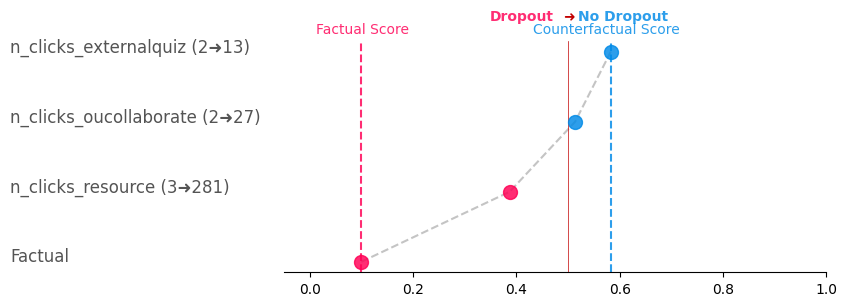

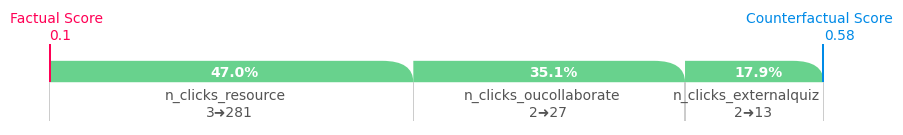

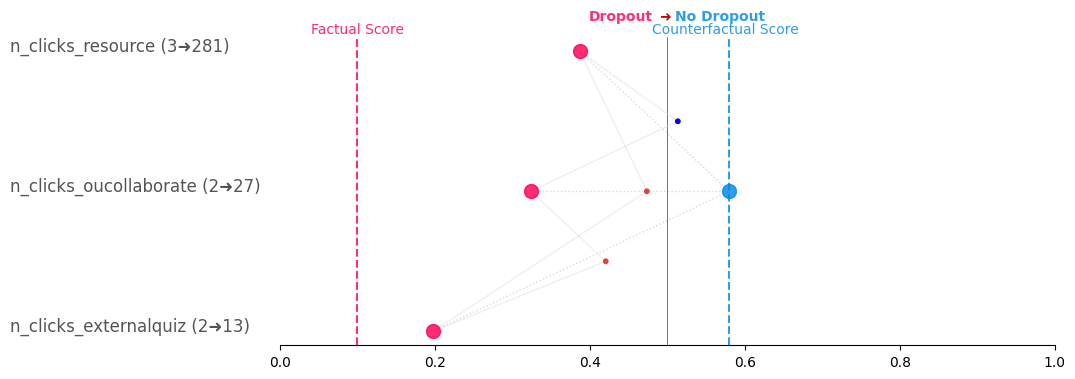

In [301]:
out_exp[1].greedy()
out_exp[1].countershapley()
out_exp[1].constellation()

### Individual counterfactuals plot

In [311]:
# Same student used as the group counterfactual plot
counterfactual_plot_instance = exp.generate_counterfactuals(dict_clusters_all_students[0].iloc[[1]], total_CFs=1, desired_class=0, features_to_vary=features_to_vary)
counterfactual_plot_instance = counterfactual_plot_instance.cf_examples_list[0].final_cfs_df
counterfactual_plot_instance.drop(columns=["final_result"], axis=1, inplace=True)

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [312]:
def model_pred(x):
    scores = exp.predict_fn(pd.concat([df_structure, pd.DataFrame(x, columns=feature_names)], ignore_index=True))
    return scores
    
feature_names = exp.data_interface.feature_names
df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
out_exp = []

out_exp.append(CreatePlot(
    factual=np.array(dict_clusters_all_students[0].iloc[1]),
    cf=np.array(counterfactual_plot_instance.squeeze()),
    model_pred=model_pred,
    feature_names=feature_names,
    class_names={0: 'No Dropout', 1: 'Dropout'}))

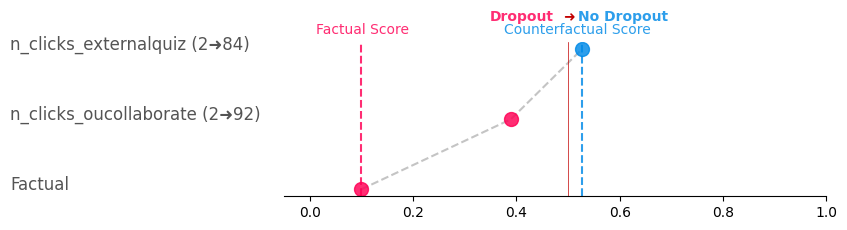

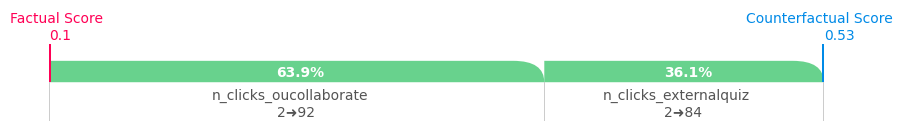

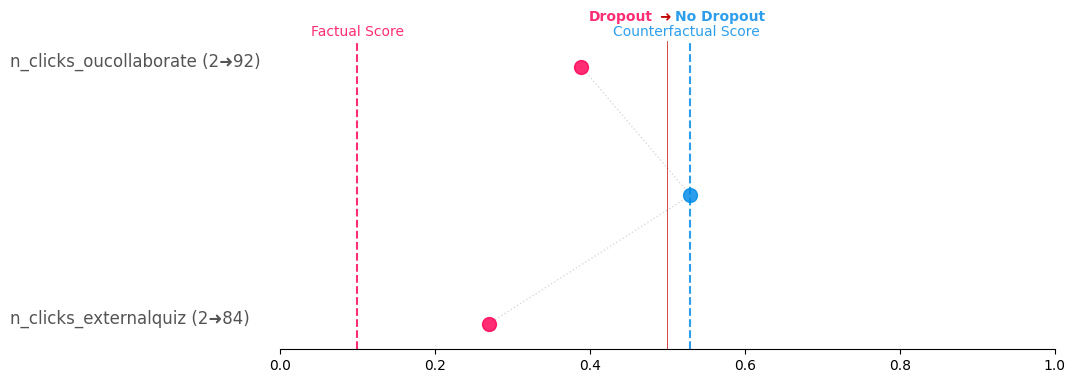

In [313]:
out_exp[0].greedy()
out_exp[0].countershapley()
out_exp[0].constellation()